In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/store-data-again/QVI_data.csv


In [2]:
# Load the data
# df = pd.read_csv('../input/store-data-again/QVI_data.csv')

In [3]:
# # look at the first five rows of the nfl_data file. 
# df.head()

In [4]:
# # get the number of missing data points per column
# missing_values_count = df.isnull().sum()

# # look at the # of missing points in the first ten columns
# missing_values_count[0:-1]

In [5]:
# # check accident data info
# df.info()

In [6]:
# # Convert DATE column to datetime
# df['DATE'] = pd.to_datetime(df['DATE'], format='%Y-%m-%d')  # Match your data's date format

# # Now create YEARMONTH safely
# df['YEARMONTH'] = df['DATE'].dt.year * 100 + df['DATE'].dt.month

In [7]:
# Read and prepare data
df = pd.read_csv('../input/store-data-again/QVI_data.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df['YEARMONTH'] = df['DATE'].dt.strftime('%Y%m')

In [8]:
# Calculate metrics by store and month
metrics = df.groupby(['STORE_NBR', 'YEARMONTH']).agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': 'nunique',
    'TXN_ID': 'nunique'
}).reset_index()

In [9]:
metrics.columns = ['STORE_NBR', 'YEARMONTH', 'totSales', 'nCustomers', 'nTransactions']
metrics['nTxnPerCust'] = metrics['nTransactions'] / metrics['nCustomers']


In [10]:
# Define trial stores and period
trial_stores = [77, 86, 88]
trial_period = ['201902', '201904']  # Feb 2019 to Apr 2019


In [11]:
# For each trial store, we'll analyze step by step
trial_store = trial_stores[0]  # Let's start with the first trial store


In [12]:
# Step 1: Calculate correlations
store_numbers = metrics['STORE_NBR'].unique()
corr_sales = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])
corr_customers = pd.DataFrame(columns=['Store1', 'Store2', 'corr_measure'])


In [14]:
# Calculate correlations for sales
for store in store_numbers:
    if store != trial_store:
        # Create a merged dataset to ensure alignment
        store_data = metrics[metrics['STORE_NBR'].isin([trial_store, store])].pivot(
            index='YEARMONTH',
            columns='STORE_NBR',
            values='totSales'
        )
        
        # Calculate correlation only if we have data for both stores
        if not store_data.empty and store_data.shape[1] == 2:
            correlation = store_data.corr().iloc[0,1]
            
            corr_sales = pd.concat([corr_sales, 
                                  pd.DataFrame({'Store1': [trial_store],
                                              'Store2': [store],
                                              'corr_measure': [correlation]})],
                                 ignore_index=True)

In [16]:
# Calculate correlations for customers
for store in store_numbers:
    if store != trial_store:
        # Create a merged dataset to ensure alignment
        store_data = metrics[metrics['STORE_NBR'].isin([trial_store, store])].pivot(
            index='YEARMONTH',
            columns='STORE_NBR',
            values='nCustomers'
        )
        
        # Calculate correlation only if we have data for both stores
        if not store_data.empty and store_data.shape[1] == 2:
            correlation = store_data.corr().iloc[0,1]
            
            corr_customers = pd.concat([corr_customers, 
                                      pd.DataFrame({'Store1': [trial_store],
                                                  'Store2': [store],
                                                  'corr_measure': [correlation]})],
                                     ignore_index=True)

In [17]:
# Step 2: Calculate magnitude distances
mag_sales = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])
mag_customers = pd.DataFrame(columns=['Store1', 'Store2', 'YEARMONTH', 'measure'])


In [19]:
# Calculate for sales using pivot and vectorized operations
# First create a pivot table for easier comparison
sales_pivot = metrics.pivot(
    index='YEARMONTH',
    columns='STORE_NBR',
    values='totSales'
).reset_index()

# For each comparison store
for store in store_numbers:
    if store != trial_store:
        # Get the data where both stores have values
        valid_data = sales_pivot[['YEARMONTH', trial_store, store]].dropna()
        
        if not valid_data.empty:
            # Calculate absolute differences
            differences = abs(valid_data[trial_store] - valid_data[store])
            
            # Create comparison DataFrame
            comparison_df = pd.DataFrame({
                'Store1': trial_store,
                'Store2': store,
                'YEARMONTH': valid_data['YEARMONTH'],
                'measure': differences
            })
            
            # Concatenate with existing results
            mag_sales = pd.concat([mag_sales, comparison_df], ignore_index=True)



In [20]:
# Standardize sales magnitude
min_max_sales = mag_sales.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
mag_sales = mag_sales.merge(min_max_sales, on=['Store1', 'YEARMONTH'])
mag_sales['mag_measure'] = 1 - (mag_sales['measure'] - mag_sales['min']) / (mag_sales['max'] - mag_sales['min'])
mag_sales = mag_sales.groupby(['Store1', 'Store2'])['mag_measure'].mean().reset_index()


In [22]:
# Calculate correlations for customers
for store in store_numbers:
    if store != trial_store:
        # Create a merged dataset to ensure alignment
        store_data = metrics[metrics['STORE_NBR'].isin([trial_store, store])].pivot(
            index='YEARMONTH',
            columns='STORE_NBR',
            values='nCustomers'
        )
        
        # Calculate correlation only if we have data for both stores
        if not store_data.empty and store_data.shape[1] == 2:
            correlation = store_data.corr().iloc[0,1]
            
            corr_customers = pd.concat([corr_customers, 
                                      pd.DataFrame({'Store1': [trial_store],
                                                  'Store2': [store],
                                                  'corr_measure': [correlation]})],
                                     ignore_index=True)

In [23]:
# Standardize customers magnitude
min_max_customers = mag_customers.groupby(['Store1', 'YEARMONTH'])['measure'].agg(['min', 'max']).reset_index()
mag_customers = mag_customers.merge(min_max_customers, on=['Store1', 'YEARMONTH'])
mag_customers['mag_measure'] = 1 - (mag_customers['measure'] - mag_customers['min']) / (mag_customers['max'] - mag_customers['min'])
mag_customers = mag_customers.groupby(['Store1', 'Store2'])['mag_measure'].mean().reset_index()


In [24]:
# Step 3: Combine scores
corr_weight = 0.5

# Combine sales scores
score_sales = corr_sales.merge(mag_sales, on=['Store1', 'Store2'])
score_sales['score'] = corr_weight * score_sales['corr_measure'] + \
                      (1 - corr_weight) * score_sales['mag_measure']


In [25]:
# Combine customer scores
score_customers = corr_customers.merge(mag_customers, on=['Store1', 'Store2'])
score_customers['score'] = corr_weight * score_customers['corr_measure'] + \
                          (1 - corr_weight) * score_customers['mag_measure']


In [26]:
# Calculate final scores
final_scores = score_sales.merge(score_customers, on=['Store1', 'Store2'], 
                               suffixes=('_sales', '_customers'))
final_scores['final_score'] = (final_scores['score_sales'] + 
                              final_scores['score_customers']) / 2


In [27]:
# Find control store
control_store = int(final_scores.sort_values('final_score', ascending=False).iloc[1]['Store2'])
print(f"Selected control store for trial store {trial_store}: {control_store}")


Selected control store for trial store 77: 2


In [28]:
# Step 4: Assess trial significance
# Calculate scaling factor
pre_trial_data = metrics[metrics['YEARMONTH'] < trial_period[0]]
scaling_factor = (pre_trial_data[pre_trial_data['STORE_NBR'] == trial_store]['totSales'].sum() / 
                 pre_trial_data[pre_trial_data['STORE_NBR'] == control_store]['totSales'].sum())


In [29]:
# Scale control store sales
control_data = metrics[metrics['STORE_NBR'] == control_store].copy()
control_data['scaled_sales'] = control_data['totSales'] * scaling_factor


In [30]:
# Calculate percentage difference
trial_data = metrics[metrics['STORE_NBR'] == trial_store]
merged_data = trial_data.merge(control_data[['YEARMONTH', 'scaled_sales']], 
                             on='YEARMONTH', suffixes=('_trial', '_control'))
merged_data['pct_diff'] = ((merged_data['totSales'] - merged_data['scaled_sales']) / 
                          merged_data['scaled_sales'] * 100)


In [31]:
# Calculate standard deviation of pre-trial percentage differences
pre_trial_std = merged_data[merged_data['YEARMONTH'] < trial_period[0]]['pct_diff'].std()


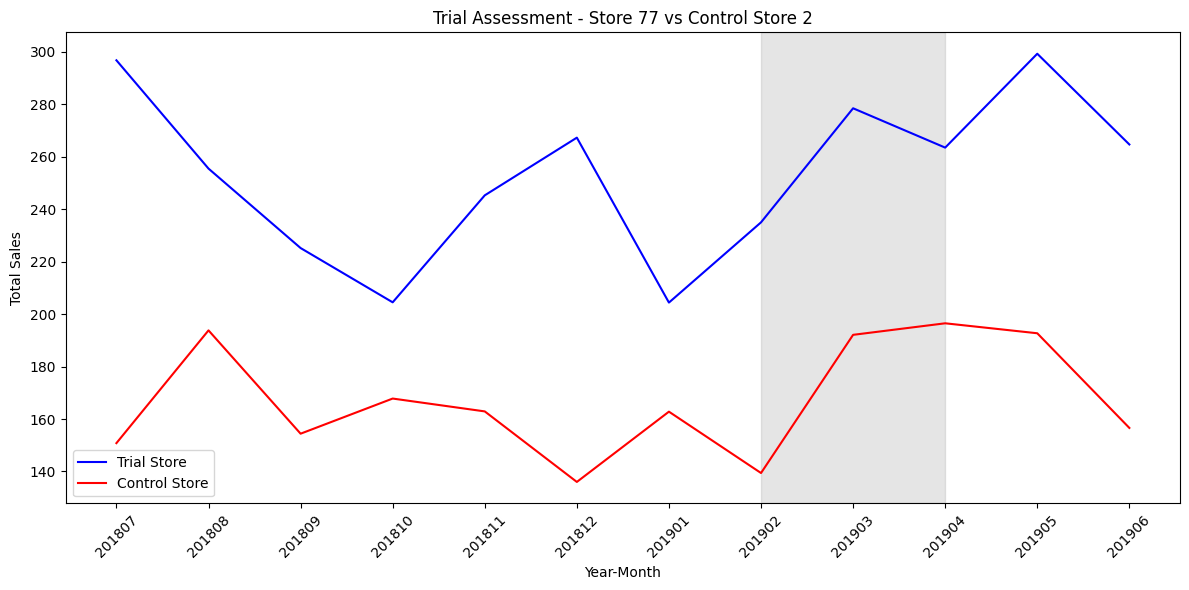

In [32]:
# Step 5: Visualize results
plt.figure(figsize=(12, 6))

# Plot trial store
plt.plot(trial_data['YEARMONTH'], trial_data['totSales'], 
         label='Trial Store', color='blue')

# Plot control store
plt.plot(control_data['YEARMONTH'], control_data['totSales'], 
         label='Control Store', color='red')

# Highlight trial period
plt.axvspan(trial_period[0], trial_period[1], alpha=0.2, color='gray')

plt.title(f'Trial Assessment - Store {trial_store} vs Control Store {control_store}')
plt.xlabel('Year-Month')
plt.ylabel('Total Sales')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()